# Record Disambiguation

In this notebook we perform entity disambiguation on records, specifically person records.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

from heritageconnector.disambiguation.helpers import load_training_data, plot_performance_curves
from heritageconnector.disambiguation.pipelines import Disambiguator

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## 1. Load data
This data has already been generated using `Disambiguator.save_training_data_to_folder` and `Disambiguator.save_test_data_to_folder`.

In [2]:
train_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/people_231020/train/"
test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/people_231020/test/"

In [3]:
X, y, pairs, pids = load_training_data(train_dir)
X_new, pairs_new, pids_new = load_training_data(test_dir)

In [5]:
pids, pids_new

(['P106', 'P569', 'P21', 'P570', 'P734', 'P735', 'label', 'P31'],
 ['P106', 'P569', 'P21', 'P570', 'P734', 'P735', 'label', 'P31'])

## 2. Train classifier
The disambiguator wraps `sklearn.tree.DecisionTreeClassifier` and takes its parameters as inputs.

### 2a. Test classifier performance
We'll perform a train/test split on the labelled data to quickly test the classifier's performance using its `score` method. 

The `score` method here returns [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html): accuracy weighted so that each class is considered evenly.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
clf = Disambiguator('PERSON').fit(X_train, y_train)
print(clf.score(X_test, y_test))

balanced accuracy score: 0.9804624906911341
precision score: 0.9288762446657184
recall score: 0.9645494830132939


### 2b. Use classifier to predict new Wikidata links

In [9]:
clf = Disambiguator('PERSON').fit(X, y)
y_pred = clf.predict(X_new, threshold=0.5)
y_pred_proba = clf.predict_proba(X_new)

print(f"{np.unique(y_pred, return_counts=True)[1][1]} potential new links found")

2506 potential new links found


In [10]:
pairs_new["y_pred"] = y_pred
pairs_new["y_pred_proba"] = y_pred_proba
pairs_new.sort_values("y_pred", ascending=False).head(20)

,internal_id,wikidata_id,y_pred,y_pred_proba
101463,https://collection.sciencemuseumgroup.org.uk/people/cp166996,Q76828,True,0.998220
94303,https://collection.sciencemuseumgroup.org.uk/people/cp133782,Q18163225,True,0.998220
20435,https://collection.sciencemuseumgroup.org.uk/people/cp106822,Q7926329,True,0.998220
3030,https://collection.sciencemuseumgroup.org.uk/people/cp161786,Q6742597,True,0.998220
107602,https://collection.sciencemuseumgroup.org.uk/people/cp44515,Q12015708,True,0.998220
53272,https://collection.sciencemuseumgroup.org.uk/people/cp84859,Q75852678,True,0.996749
131879,https://collection.sciencemuseumgroup.org.uk/people/cp136902,Q6786928,True,0.998220
94309,https://collection.sciencemuseumgroup.org.uk/people/cp133782,Q52218610,True,0.923343
75072,https://collection.sciencemuseumgroup.org.uk/people/cp133925,Q52155667,True,0.998220
111399,https://collection.sciencemuseumgroup.org.uk/people/cp36055,Q20492565,True,0.998220


The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches.

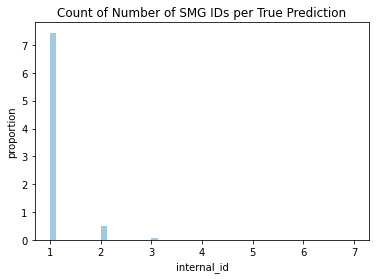

In [11]:
display(Markdown("The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches."))
sns.distplot(pairs_new.loc[pairs_new["y_pred"] == True, "internal_id"].value_counts(), kde=False, norm_hist=True).set_ylabel('proportion')
plt.gca().set_title('Count of Number of SMG IDs per True Prediction');

## 2c. Returning top-ranked links only
We can filter some of the duplicate Wikidata candidates for each SMG item found above by _only returning the top-ranked positive matches_. `clf.predict_top_ranked_pairs` does this.

In [12]:
pairs_true = clf.predict_top_ranked_pairs(X_new, pairs_new)
print(f"No. new links: {len(pairs_true)}")
print(f"No. SMG items with new links: {len(pairs_true['internal_id'].unique())}")
pairs_true.head()

No. new links: 2411
No. SMG items with new links: 2320


,internal_id,wikidata_id,y_pred,y_pred_proba
49,https://collection.sciencemuseumgroup.org.uk/people/cp94357,Q75421470,True,0.960995
59,https://collection.sciencemuseumgroup.org.uk/people/cp17013,Q18528681,True,0.998220
77,https://collection.sciencemuseumgroup.org.uk/people/cp16491,Q7347877,True,0.998220
126,https://collection.sciencemuseumgroup.org.uk/people/cp137207,Q29554021,True,0.983339
248,https://collection.sciencemuseumgroup.org.uk/people/cp124380,Q43376653,True,0.827308


## 3. Explain classifier
We can see that the classifier prioritises P569/P570 (birth and death dates), P21 (gender), label similarity, and occupation.

It's interesting to note that P31 (instance of), which tells the classifier whether the Wikidata record is a human, is not used. This is likely because P569/P570/P106/P21 are qualities which only humans can have.

P31 is likely to be much more prevalent when classifying objects, and distinguishing between e.g. paintings and posters.

In [13]:
clf.print_tree(feature_names=pids)

|--- P569 <= 1.00
|   |--- P106 <= 0.50
|   |   |--- P570 <= 1.00
|   |   |   |--- label <= 0.99
|   |   |   |   |--- P735 <= 0.03
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P735 >  0.03
|   |   |   |   |   |--- class: False
|   |   |   |--- label >  0.99
|   |   |   |   |--- P21 <= 0.50
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P21 >  0.50
|   |   |   |   |   |--- class: False
|   |   |--- P570 >  1.00
|   |   |   |--- label <= 0.94
|   |   |   |   |--- class: False
|   |   |   |--- label >  0.94
|   |   |   |   |--- P734 <= 0.97
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P734 >  0.97
|   |   |   |   |   |--- class: True
|   |--- P106 >  0.50
|   |   |--- label <= 0.95
|   |   |   |--- label <= 0.87
|   |   |   |   |--- P570 <= 0.28
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P570 >  0.28
|   |   |   |   |   |--- class: False
|   |   |   |--- label >  0.87
|   |   |   |   |--- P569 <= 0.90
|   |   |   |   |   |--- class: 

## 4. Export model & sample of predictions

In [14]:
clf.save_classifier_to_disk("/Volumes/Kalyan_SSD/SMG/disambiguation/people_231020/clf.pkl")

In [13]:
pairs_pos_sample = pairs_new[pairs_new['y_pred'] == True].sample(30, random_state=42)
pairs_neg_sample = pairs_new[pairs_new['y_pred'] == False].sample(30, random_state=42)

pairs_sample = pd.concat([pairs_pos_sample, pairs_neg_sample], ignore_index=False)
pairs_sample = pairs_sample.copy()
pairs_sample['wikidata_id'] = "https://www.wikidata.org/entity/" + pairs_sample['wikidata_id']

pairs_sample.to_excel("people_classifier_sample_for_review.xlsx")